In [2]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
filtered_df = pd.read_parquet("../.data/processed/filtered_user_features.parquet")

In [4]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Liste des variables retenues
features = [
    "count_view", "count_cart", "count_purchase",
    "unique_sessions", "active_days", "recency_days",
    "total_spent", "avg_purchase_price"
]

# Filtrage des utilisateurs actifs déjà effectué dans filtered_df
X = filtered_df[features].copy()

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7841232 entries, 0 to 7841231
Data columns (total 8 columns):
 #   Column              Dtype  
---  ------              -----  
 0   count_view          int64  
 1   count_cart          int64  
 2   count_purchase      int64  
 3   unique_sessions     int64  
 4   active_days         int64  
 5   recency_days        int64  
 6   total_spent         float64
 7   avg_purchase_price  float64
dtypes: float64(2), int64(6)
memory usage: 478.6 MB


In [12]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Copie de X pour transformation
X_transformed = X.copy()

# Variables à transformer avec log(1 + x)
log_features = ["count_view", "count_cart",
                "count_purchase", "total_spent", "avg_purchase_price"]
X_transformed[log_features] = X_transformed[log_features].apply(
    lambda x: np.log1p(x))

# Standardisation finale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)

In [16]:
len(X_scaled)

7841232

INFO:__main__:Training KMeans with k=2 on 100000 samples...
INFO:__main__:k=2: Inertia=713659.87, Silhouette=0.9966
INFO:__main__:Training KMeans with k=3 on 100000 samples...
INFO:__main__:k=3: Inertia=387310.15, Silhouette=0.5334
INFO:__main__:Training KMeans with k=4 on 100000 samples...
INFO:__main__:k=4: Inertia=318107.69, Silhouette=0.5030
INFO:__main__:Training KMeans with k=5 on 100000 samples...
INFO:__main__:k=5: Inertia=253940.34, Silhouette=0.3503
INFO:__main__:Training KMeans with k=6 on 100000 samples...
INFO:__main__:k=6: Inertia=211715.23, Silhouette=0.3644
INFO:__main__:Training KMeans with k=7 on 100000 samples...
INFO:__main__:k=7: Inertia=187117.69, Silhouette=0.3529
INFO:__main__:Training KMeans with k=8 on 100000 samples...
INFO:__main__:k=8: Inertia=171586.64, Silhouette=0.3489
INFO:__main__:Training KMeans with k=9 on 100000 samples...
INFO:__main__:k=9: Inertia=158264.62, Silhouette=0.3121
INFO:__main__:Training KMeans with k=10 on 100000 samples...
INFO:__main

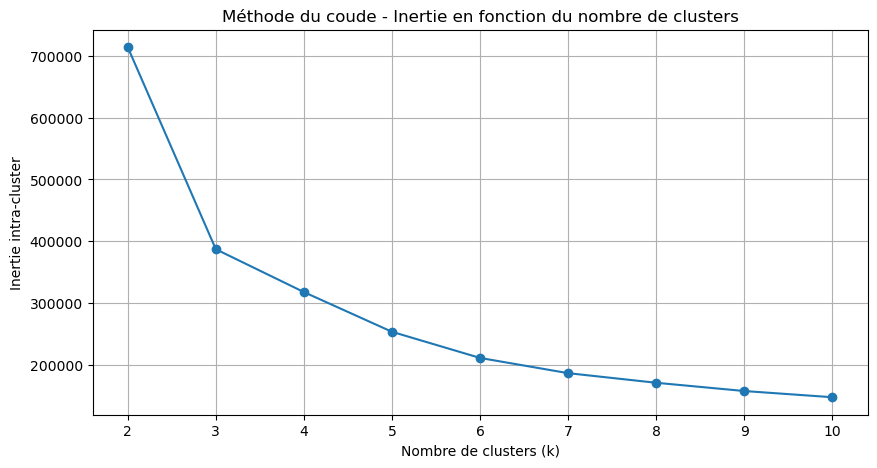

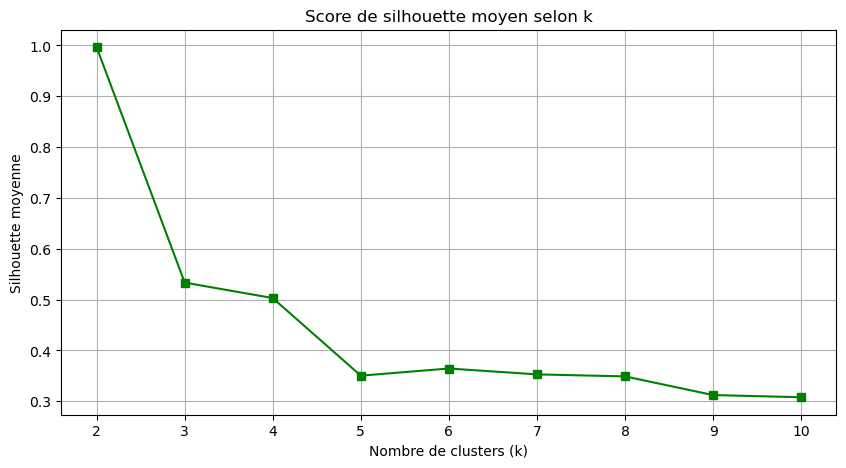

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import logging

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

sample_size = 100_000
np.random.seed(42)

# Créer un échantillon de lignes aléatoires à partir de X_scaled
indices = np.random.choice(X_scaled.shape[0], size=sample_size, replace=False)
X_sampled = X_scaled[indices]
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    logger.info(f"Training KMeans with k={k} on {sample_size} samples...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(X_sampled)

    inertia = kmeans.inertia_
    silhouette = silhouette_score(X_sampled, kmeans.labels_)

    logger.info(f"k={k}: Inertia={inertia:.2f}, Silhouette={silhouette:.4f}")

    inertias.append(inertia)
    silhouette_scores.append(silhouette)

# Courbe du coude
plt.figure(figsize=(10, 5))
plt.plot(k_range, inertias, marker='o')
plt.title("Méthode du coude - Inertie en fonction du nombre de clusters")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie intra-cluster")
plt.grid(True)
plt.show()

# Score silhouette
plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, marker='s', color='green')
plt.title("Score de silhouette moyen selon k")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Silhouette moyenne")
plt.grid(True)
plt.show()

In [32]:
best_k = 6
final_model = KMeans(n_clusters=best_k, random_state=42,
                     n_init=10, max_iter=300)
final_model.fit(X_scaled)

KMeans(n_clusters=6, n_init=10, random_state=42)

In [33]:
import joblib
joblib.dump(final_model, "../models/kmeans_model_k6.pkl")
print(f"Modèle final entraîné avec k={best_k} et sauvegardé.")

Modèle final entraîné avec k=6 et sauvegardé.


In [34]:
joblib.dump(scaler, "../models/scaler.pkl")

['../models/scaler.pkl']

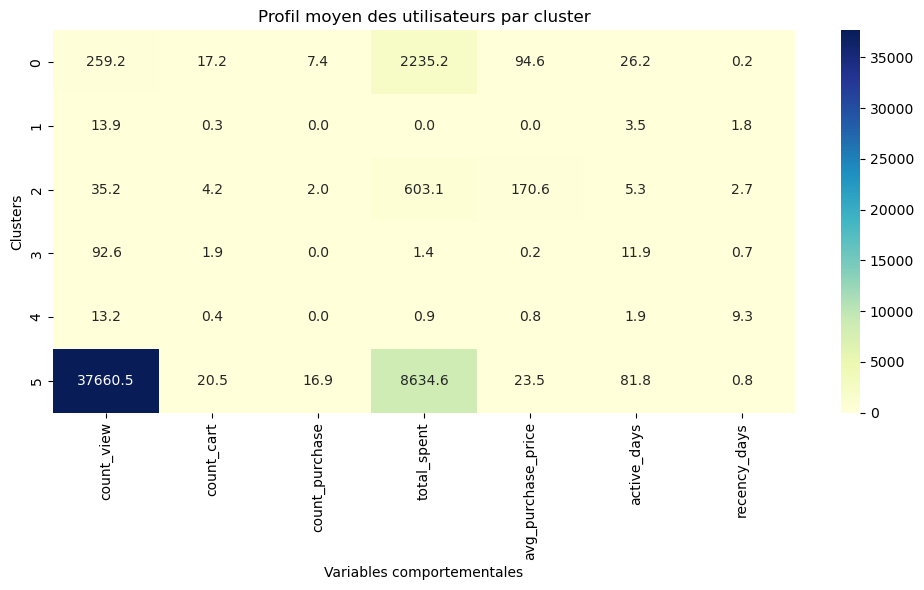

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 1. Prédiction des clusters pour tout le dataset (ou un sous-échantillon)
# On suppose que kmeans est déjà entraîné et X_scaled est le jeu de données normalisé
filtered_df["cluster"] = final_model.predict(X_scaled)

# 2. Moyenne des variables par cluster (profilage)
cluster_profile = filtered_df.groupby("cluster")[
    ["count_view", "count_cart", "count_purchase",
     "total_spent", "avg_purchase_price",
     "active_days", "recency_days"]
].mean().round(1)

# 3. Affichage de la heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_profile, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Profil moyen des utilisateurs par cluster")
plt.xlabel("Variables comportementales")
plt.ylabel("Clusters")
plt.tight_layout()
plt.show()

In [11]:
import joblib
# 4. Sauvegarde du modèle KMeans entraîné
joblib.dump(kmeans, "../models/kmeans_model.pkl")

# 5. Sauvegarde du scaler utilisé pour la normalisation
joblib.dump(scaler, "../models/scaler.pkl")

['../models/scaler.pkl']